# MMA 867 - Individual Assignment - 3

## Predicting COVID-19 cases using TimeSeries Analysis

## By Gopala Goyal - 20254605

> As a part of the assignment, we would be working on the Covid dataset and forcasting the New Covid-19 Cases in the US using timeseries analysis

In [1]:
#Import the required libraries
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib as mplt
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
from datetime import datetime, timedelta
%matplotlib inline

### Data Exploration

In [2]:
#Load the dataset
df_covid=pd.read_csv("owid-covid-data.csv")

In [3]:
#Check the null values in the dataset
df_covid.isna().sum()

iso_code                           0
continent                       5344
location                           0
date                               0
total_cases                     5732
                               ...  
handwashing_facilities         64786
hospital_beds_per_thousand     22621
life_expectancy                 6003
human_development_index        13160
excess_mortality              112804
Length: 62, dtype: int64

In [4]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116807 entries, 0 to 116806
Data columns (total 62 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   iso_code                               116807 non-null  object 
 1   continent                              111463 non-null  object 
 2   location                               116807 non-null  object 
 3   date                                   116807 non-null  object 
 4   total_cases                            111075 non-null  float64
 5   new_cases                              111072 non-null  float64
 6   new_cases_smoothed                     110057 non-null  float64
 7   total_deaths                           100421 non-null  float64
 8   new_deaths                             100576 non-null  float64
 9   new_deaths_smoothed                    110057 non-null  float64
 10  total_cases_per_million                110489 non-null  

In [5]:
#Checking the statistics of various variables
df_covid.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
count,1.110750e+05,111072.000000,110057.000000,1.004210e+05,100576.000000,110057.000000,110489.000000,110486.000000,109476.000000,99848.000000,...,69745.000000,103553.000000,106682.000000,80881.000000,79705.000000,52021.000000,94186.000000,110804.000000,103647.000000,4003.000000
mean,1.354885e+06,6423.650911,6438.922915,3.480560e+04,145.968849,132.702924,16703.178299,81.513726,81.479976,353.666743,...,13.465236,259.119244,8.001839,10.596205,32.731274,50.756233,3.024659,73.258880,0.726673,18.064269
std,9.104489e+06,39317.057192,38895.755497,2.075685e+05,796.005158,743.966548,28912.479820,190.090310,161.294316,608.001663,...,19.978299,119.279548,4.259676,10.506179,13.499370,31.754145,2.453891,7.544932,0.150256,35.095659
min,1.000000e+00,-74347.000000,-6223.000000,1.000000e+00,-1918.000000,-232.143000,0.001000,-3125.829000,-272.971000,0.001000,...,0.100000,79.370000,0.990000,0.100000,7.700000,1.188000,0.100000,53.280000,0.394000,-95.590000
25%,1.825000e+03,3.000000,8.857000,6.400000e+01,0.000000,0.000000,319.769000,0.274000,1.488000,9.705500,...,0.600000,168.711000,5.310000,1.900000,21.600000,19.351000,1.300000,67.920000,0.602000,0.645000
50%,1.863900e+04,89.000000,110.000000,5.630000e+02,2.000000,1.571000,2494.790000,10.235500,13.932000,63.792000,...,2.200000,243.811000,7.110000,6.300000,31.400000,49.839000,2.400000,74.620000,0.744000,7.640000
75%,1.991870e+05,902.000000,951.857000,4.867000e+03,18.000000,15.429000,19434.909000,79.054750,88.076000,422.042250,...,21.200000,329.942000,10.080000,19.300000,41.100000,82.502000,3.861000,78.740000,0.848000,23.595000
max,2.258059e+08,905932.000000,826340.429000,4.648435e+06,17976.000000,14722.714000,208199.373000,8620.690000,3385.473000,5960.536000,...,77.600000,724.417000,30.530000,44.000000,78.100000,100.000000,13.800000,86.750000,0.957000,410.900000


In [97]:
df_covid.date.min()

'2020-01-01'

In [6]:
#In Python to ease out the process of plotting and doing the TimeSeries Analysis, we make the Date field as the index of the dataframe
df_covid.index = pd.to_datetime(df_covid.date)

In [7]:
df_covid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2020-02-25,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2020-02-26,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2020-02-27,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2020-02-28,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN


In [8]:
#As per the assignment, we need to forecase the cases for Canada, so we created a new dataframe which is a subset of the whole dataframe loaded above
df_covid_can = df_covid[df_covid.iso_code == 'CAN']

In [9]:
df_covid_can.shape

(598, 62)

In [10]:
df_covid_can.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
date,,,,,,,,,,,,,,,,,,,,,
2020-01-26,CAN,North America,Canada,2020-01-26,1.0,1.0,NaN,NaN,NaN,NaN,...,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,4.2
2020-01-27,CAN,North America,Canada,2020-01-27,1.0,0.0,NaN,NaN,NaN,NaN,...,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN
2020-01-28,CAN,North America,Canada,2020-01-28,2.0,1.0,NaN,NaN,NaN,NaN,...,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN
2020-01-29,CAN,North America,Canada,2020-01-29,2.0,0.0,NaN,NaN,NaN,NaN,...,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN
2020-01-30,CAN,North America,Canada,2020-01-30,2.0,0.0,NaN,NaN,NaN,NaN,...,0.5,105.599,7.37,12.0,16.6,NaN,2.5,82.43,0.929,NaN


In [11]:
df_covid_can = df_covid_can.iloc[40:]

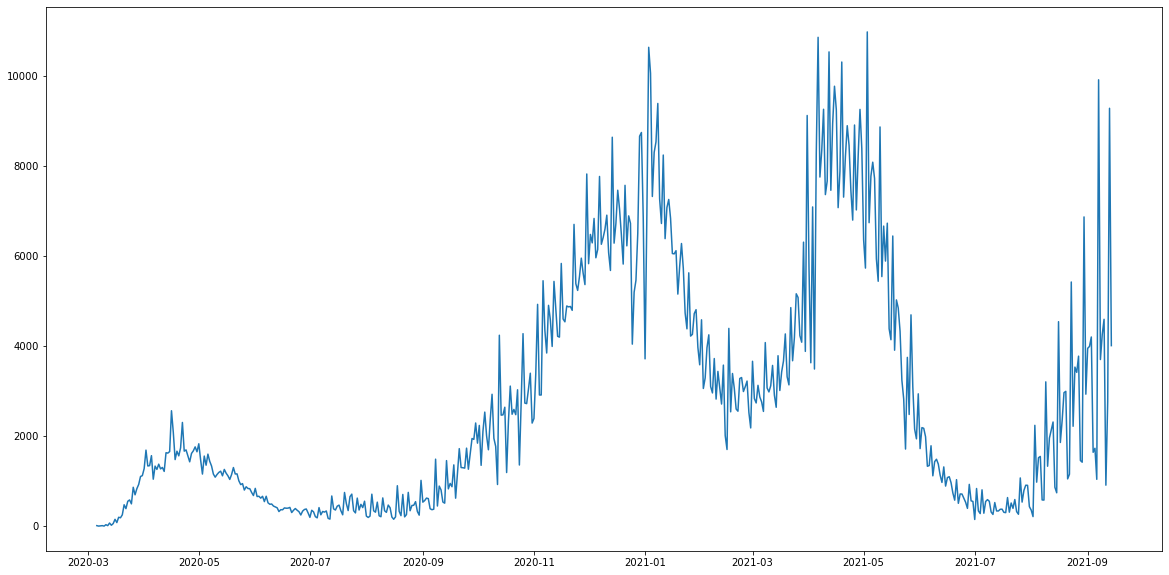

In [12]:
#plot the Canada Covid new cases TS data

plt.figure(figsize = (20,10))
fig = plt.figure(1)
plt.plot(df_covid_can['new_cases'])

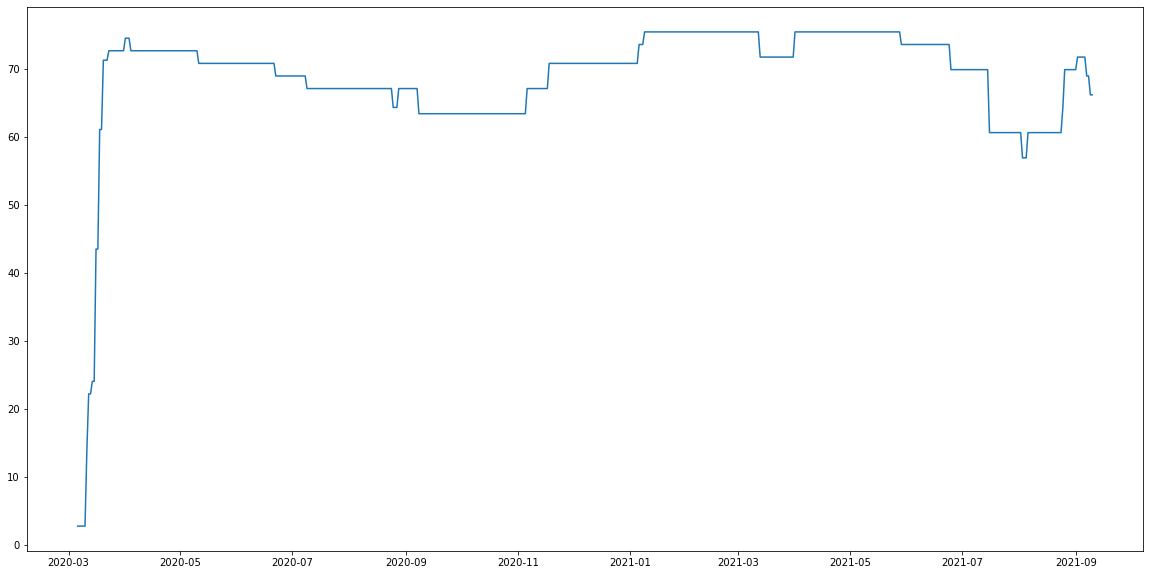

In [13]:
#plot the Canada Covid Stringency index TS data

plt.figure(figsize = (20,10))
fig = plt.figure(1)
plt.plot(df_covid_can['stringency_index'])

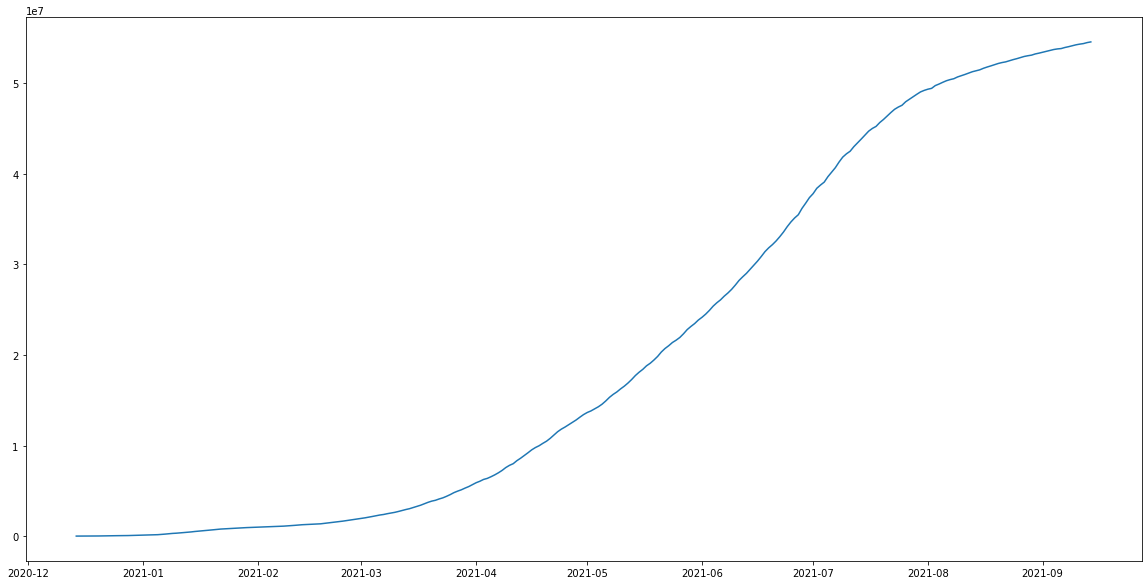

In [14]:
#plot the Canada Covid vaccinations TS data

plt.figure(figsize = (20,10))
fig = plt.figure(1)
plt.plot(df_covid_can['total_vaccinations'])

### Checking Stationarity of data

> 1. Using Rolling Statistics

> 2. Using the Duckey Fuller test

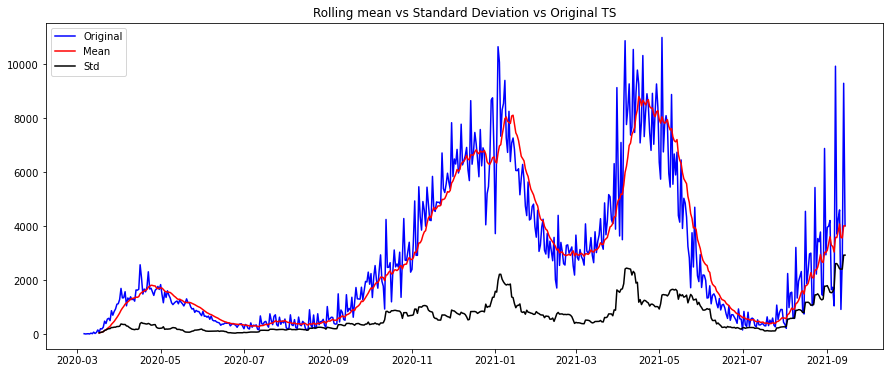

In [15]:
rolling_mean = df_covid_can['new_cases'].rolling(12).mean()
rolling_std = df_covid_can['new_cases'].rolling(12).std()

plt.figure(figsize = (15,6))
orig = plt.plot(df_covid_can['new_cases'], color = 'blue', label='Original')
rol_mean = plt.plot(rolling_mean, color = 'red', label='Mean')
rol_std = plt.plot(rolling_std, color = 'black', label='Std')

plt.legend(loc = 'best')
plt.title('Rolling mean vs Standard Deviation vs Original TS')
plt.show()

> According to the above plot, we see that the variance/standard deviation increases with the mean

> The data has a trends as we can see the fluctuations and hence the data is **non-stationary**

> The data has seasonality as there are certain repeating spikes/pattern on some days like on the weekdays

## Pre-Processing

In [16]:
#To make the data stationary, we will try to make the data as normal using log-transformation

covid_can_log = np.log(df_covid_can['new_cases'])

<function matplotlib.pyplot.show(close=None, block=None)>

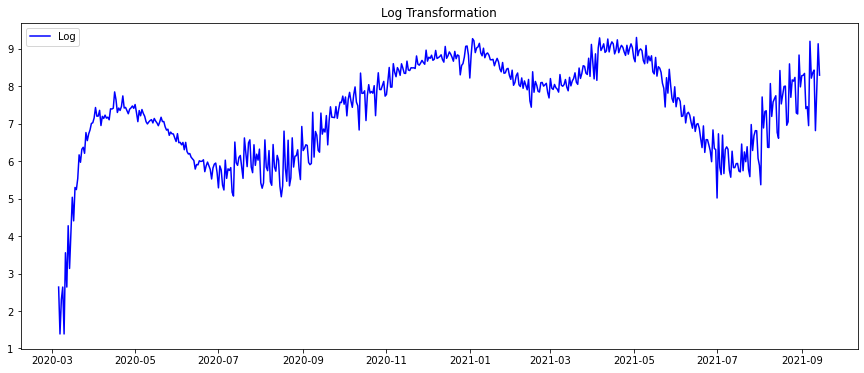

In [17]:
plt.figure(figsize = (15,6))
plt.plot(covid_can_log, color = 'blue', label='Log')
plt.legend(loc = 'best')
plt.title("Log Transformation")
plt.show

In [18]:
box_cox_data, box_cox_lambda = boxcox(df_covid_can['new_cases'])

In [19]:
print(box_cox_lambda)

0.2440474453877445


<function matplotlib.pyplot.show(close=None, block=None)>

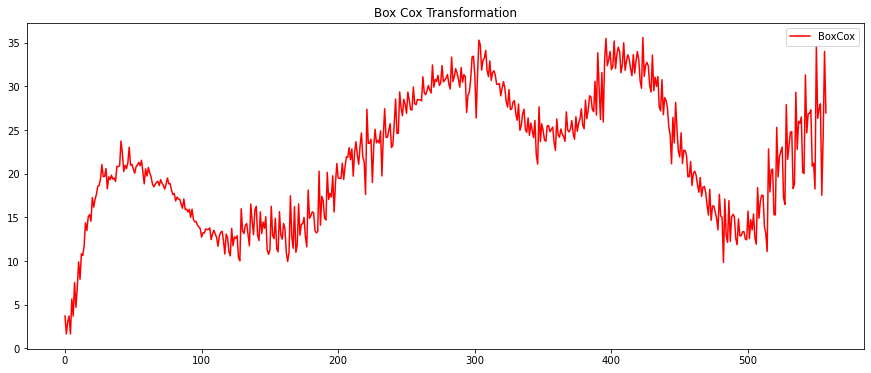

In [20]:
plt.figure(figsize = (15,6))
plt.plot(box_cox_data, color = 'red', label='BoxCox')
plt.legend(loc = 'best')
plt.title("Box Cox Transformation")
plt.show

> Box Cox transformation did not perform well on hte data in comparison to the log transformation hence we will be using the log transformation to perform the forecasting

### Applying seasonal decomposition

> Here, we would be separating the time series into different components and checking what is contributing more towards the timeseries stationarity

In [21]:
decomp = seasonal_decompose(covid_can_log, period = 7, model = 'multiplicative')

In [22]:
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

<function matplotlib.pyplot.show(close=None, block=None)>

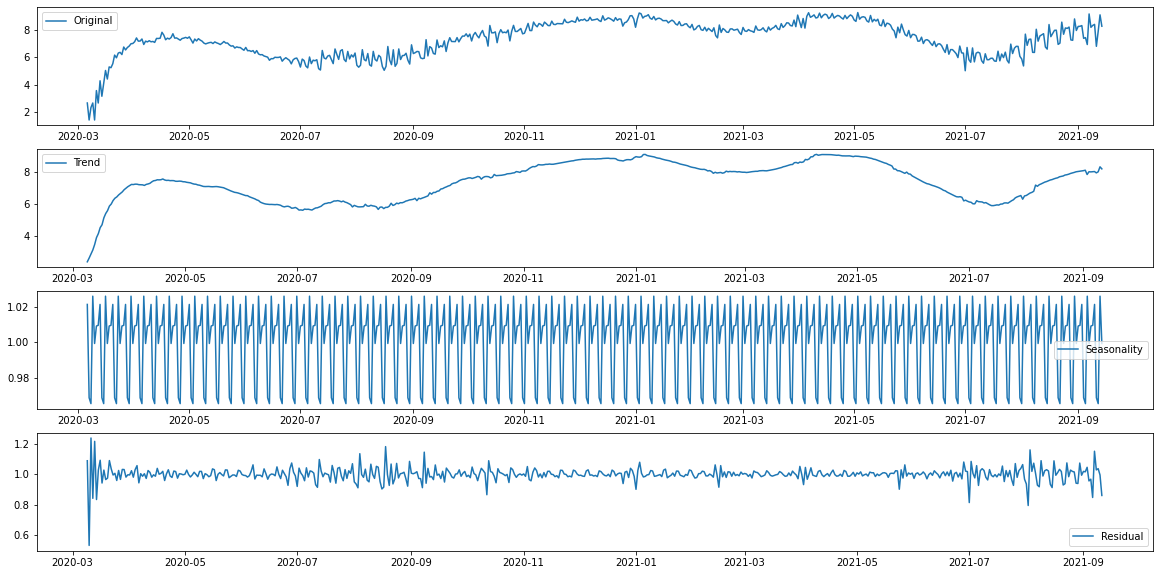

In [23]:
plt.figure(figsize = (20,10))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(covid_can_log, label='Original')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc = 'best')

plt.show

> According to the above graph, it is evident that there is a constant seasonality in the data

> The trend is driving the TimeSeries and it is because of the trend that we can see the non-stationarity

> We would now perform differencing on the trend to make the TimeSeries stationary (and detect the seasonality????)

<function matplotlib.pyplot.show(close=None, block=None)>

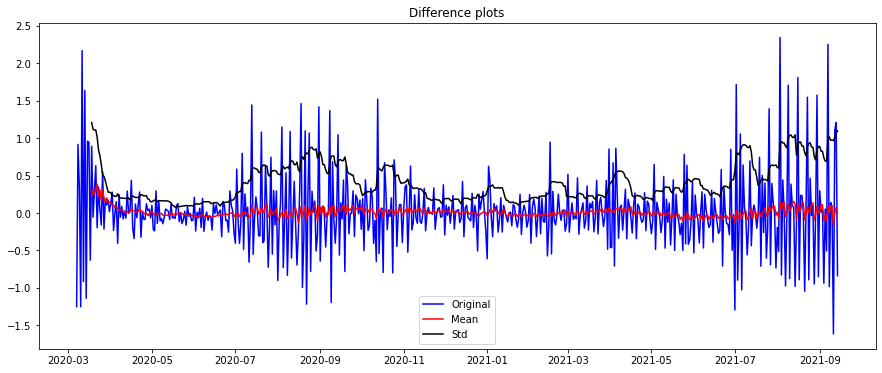

In [24]:
#Calculate the difference
covid_can_log_diff = covid_can_log - covid_can_log.shift()

#Calculate difference statistics
roll_mean_diff = covid_can_log_diff.rolling(12).mean()
roll_std_diff = covid_can_log_diff.rolling(12).std()

#plot the difference

plt.figure(figsize = (15,6))

plt.plot(covid_can_log_diff, color = 'blue', label='Original')
rol_mean_diff = plt.plot(roll_mean_diff, color = 'red', label='Mean')
rol_std_diff = plt.plot(roll_std_diff, color = 'black', label='Std')

plt.legend(loc = 'best')
plt.title("Difference plots")
plt.show

### Plotting ACF & PACF for Differenced TimeSeries

In [25]:
lag_acf = acf(covid_can_log_diff, nlags = 7)
lag_pacf = pacf(covid_can_log_diff, nlags = 7)

/Users/apple/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


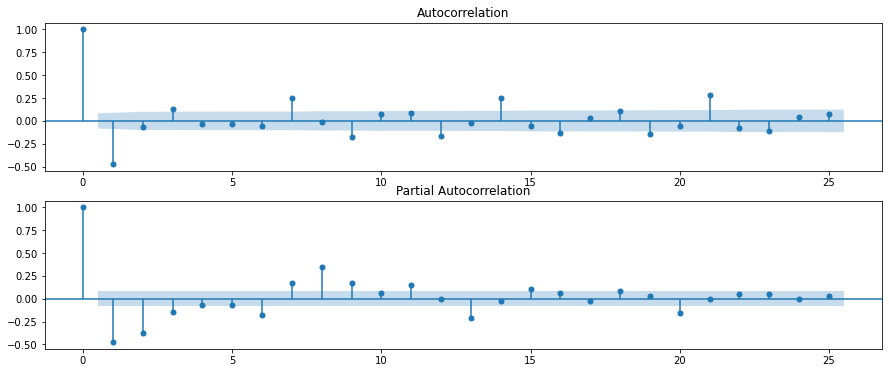

In [26]:
import statsmodels.api as sm

fig = plt.figure(figsize = (15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(covid_can_log_diff.dropna(),lags = 25, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(covid_can_log_diff.dropna(),lags = 25, ax = ax2)

/Users/apple/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred

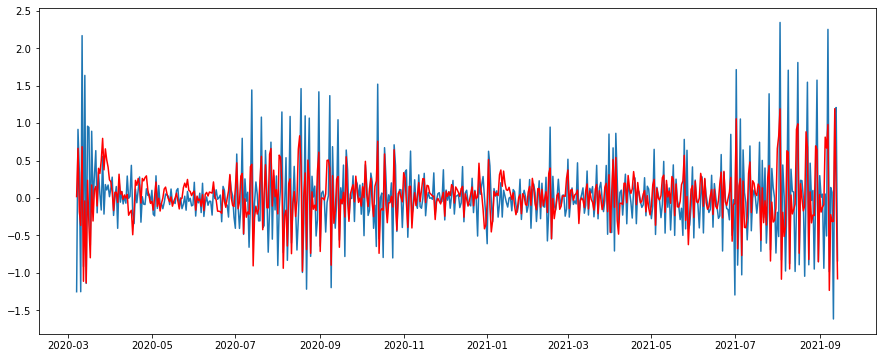

In [107]:
plt.figure(figsize = (15,6))
model = ARIMA(covid_can_log, order = (2,1,2))
results = model.fit(disp=1)
plt.plot(covid_can_log_diff)
plt.plot(results.fittedvalues, color = 'red')

In [108]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.new_cases   No. Observations:                  557
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -231.597
Method:                       css-mle   S.D. of innovations              0.366
Date:                Wed, 15 Sep 2021   AIC                            475.194
Time:                        23:41:53   BIC                            501.129
Sample:                    03-07-2020   HQIC                           485.324
                         - 09-14-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0187      0.017      1.114      0.265      -0.014       0.052
ar.L1.D.new_cases     0.9207      0.049     18.789      0.000       0.825       1.017
ar.L2.D.new_cases     0.0118      0.050      0.237      0.813      -0.086       0.110
ma.L1.D.new_cases    -1.7962      0.026    -70.412      0.000      -1.846      -1.746
ma.L2.D.new_cases     0.8696      0.023     37.162      0.000       0.824       0.916
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0714           +0.0000j            1.0714            0.0000
AR.2          -78.8607           +0.0000j           78.8607            0.5000
MA.1            1.0327           -0.2888j            1.0723           -0.0434
MA.2            1.0327           +0.2888j            1.0723            0.0434
-----------------------------------------------------------------------------
"""

In [49]:
#Create a user defined function to run Arima model
def runArima(timeseries, seasonal):
    model = pm.auto_arima(timeseries,
                      test='adf',      
                      m=1,             
                      d=None,          
                      seasonal=seasonal,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    print(model.summary())
    return model

In [101]:
def predictArimaAndPlot(model_p, timeseries, logged):
    # Forecast
    n_periods = 15

    fc, confint = model_p.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(date, periods=15)

    # Plot
    plt.figure(figsize = (30,15))
    plt.plot(timeseries)
    if(logged):
         # make series for plotting purpose
        fc_series = pd.Series(fc, index=index_of_fc)
        exp_fc_series = pd.Series(np.exp(fc_series), index=index_of_fc)
        print(exp_fc_series)
        lower_series_l = pd.Series(confint[:, 0], index=index_of_fc)
        upper_series_l = pd.Series(confint[:, 1], index=index_of_fc)
        plt.plot(exp_fc_series, color='darkgreen')
        plt.fill_between(lower_series_l.index, lower_series_l, upper_series_l, color='k', alpha=.15)
    else:
         # make series for plotting purpose
        fc_series = pd.Series(fc, index=index_of_fc)
        print(fc_series)
        lower_series = pd.Series(confint[:, 0], index=index_of_fc)
        upper_series = pd.Series(confint[:, 1], index=index_of_fc)
        plt.plot(fc_series, color='darkgreen')
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)

    plt.title("Final Forecast of ...")
    plt.show()


### Assignment Question 1 - Run code for non-preprocessed data

In [52]:
model_q1 = runArima(df_covid_can['new_cases'],True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9180.163, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9537.161, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9409.020, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9264.639, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9535.180, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9263.358, Time=0.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9236.694, Time=0.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9184.853, Time=1.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9262.952, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9180.732, Time=0.96 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9239.197, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=9178.470, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9

/Users/apple/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


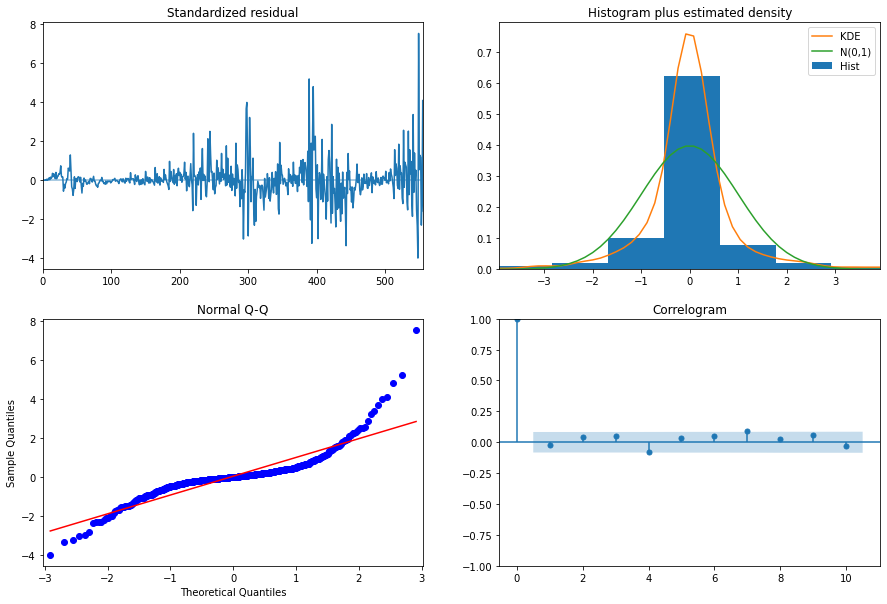

In [92]:
model_q1.plot_diagnostics(figsize=(15,10))
plt.show()

2021-09-14    3840.723950
2021-09-15    5186.259147
2021-09-16    5237.289021
2021-09-17    3721.394591
2021-09-18    4353.828815
2021-09-19    5682.587425
2021-09-20    4587.980046
2021-09-21    3829.973569
2021-09-22    5256.193565
2021-09-23    5339.799603
2021-09-24    3849.865036
2021-09-25    4399.061215
2021-09-26    5621.407016
2021-09-27    4545.701979
2021-09-28    3829.176602
Freq: D, dtype: float64


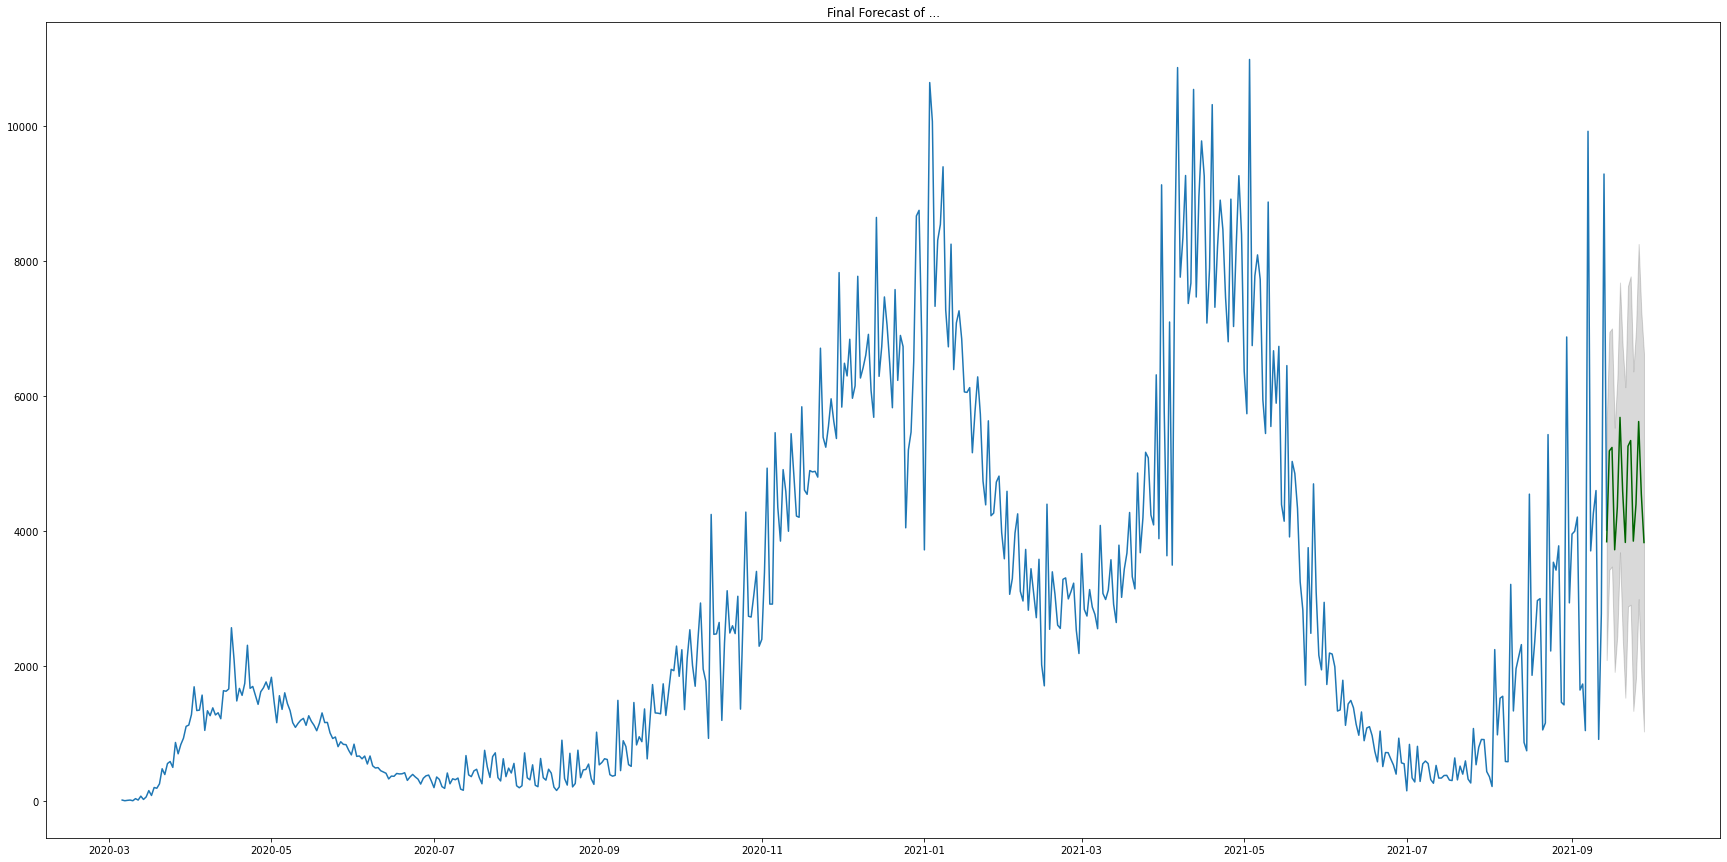

In [102]:
#run prediction and plot
predictArimaAndPlot(model_q1, df_covid_can['new_cases'], False)

### Answer 2 - Run code on Pre-Processed data

In [94]:
model_q2 = runArima(covid_can_log,True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=548.466, Time=1.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=783.472, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=641.986, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=560.701, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=781.714, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=473.250, Time=2.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=553.445, Time=0.75 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=556.849, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=475.194, Time=1.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=523.788, Time=0.79 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=546.474, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=471.984, Time=1.76 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=474.055, Time=1.81 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=510.533, Time=2.23 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=471.2

/Users/apple/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


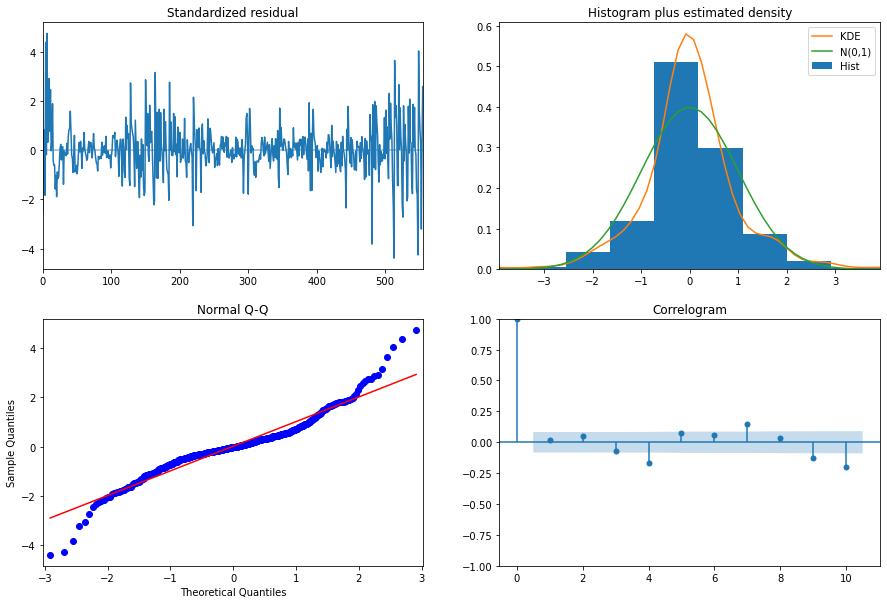

In [93]:
model_q2.plot_diagnostics(figsize=(15,10))
plt.show()

2021-09-14    2464.655758
2021-09-15    4119.759411
2021-09-16    4797.513874
2021-09-17    2960.129460
2021-09-18    3456.998958
2021-09-19    5701.569762
2021-09-20    4262.688856
2021-09-21    3190.547539
2021-09-22    5218.819093
2021-09-23    6016.937130
2021-09-24    3706.440607
2021-09-25    4246.050000
2021-09-26    6876.670361
2021-09-27    5143.076183
Freq: D, dtype: float64


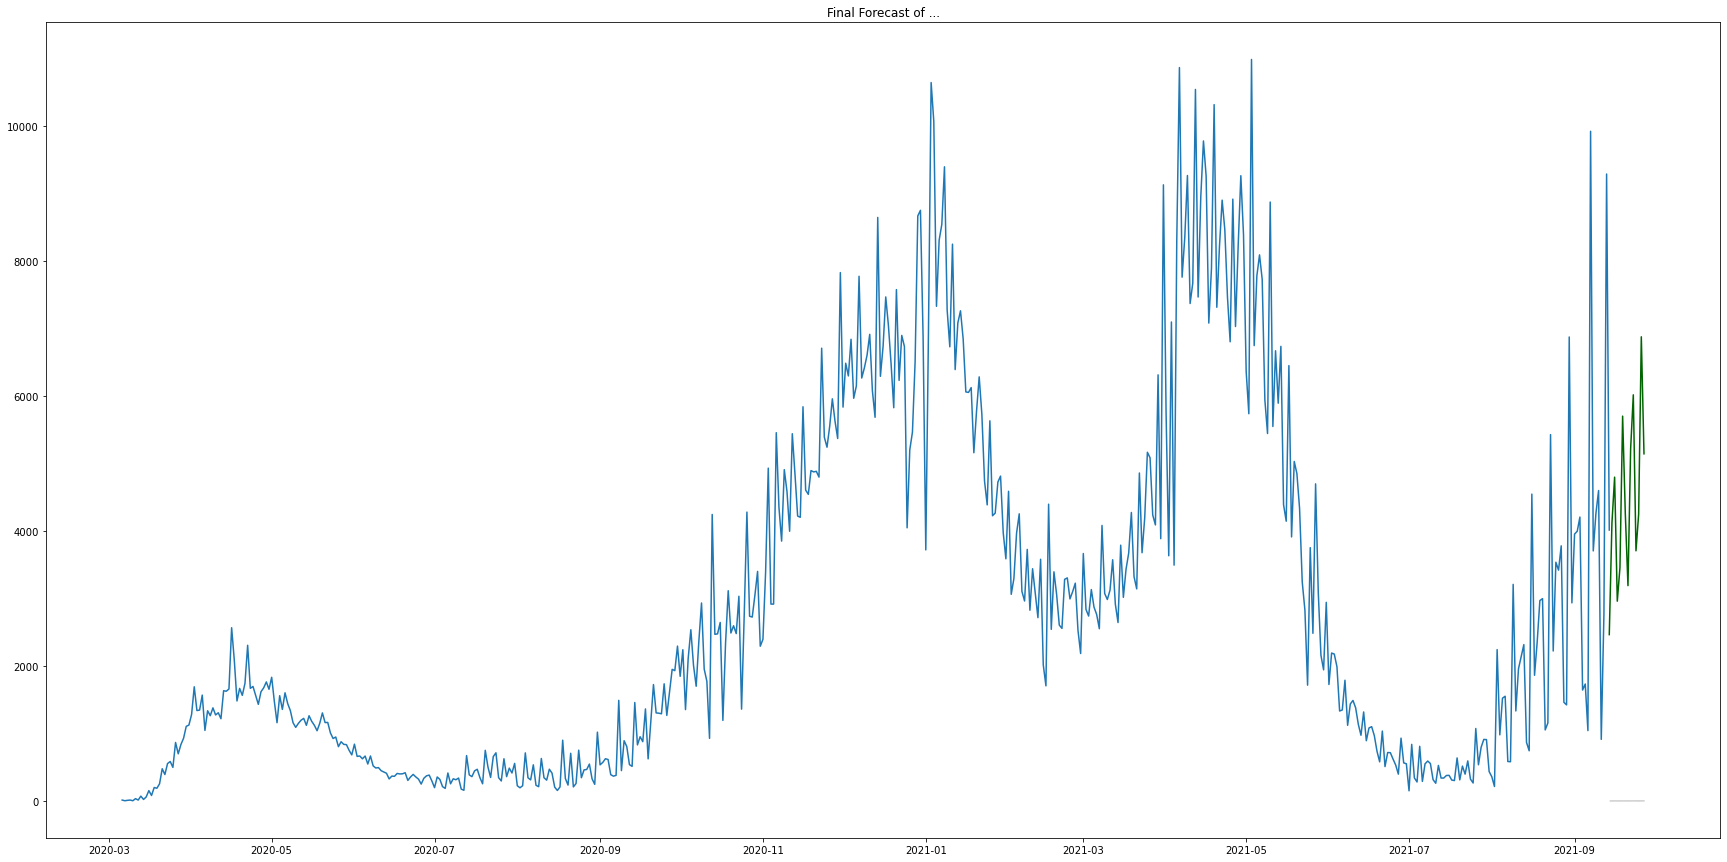

In [95]:
predictArimaAndPlot(model_q2,df_covid_can['new_cases'], True)

### Answer 4 - Improvement using different Orders

/Users/apple/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred